# **Detection of Brain Tumour MRI Images using Convolutional Neural Networks and Traditional Machine Learning Algorithms**

_A Final Project for the course: Machine Learning in Synthetic Biology_

**Author: Chigozie Nkwocha**

---

## **Aim**

To classify brain tumour MRI scan images into four classes: No tumours, glioma
tumours, meningioma tumours and pituitary tumours using traditional and modern machine learning
(CNN) models. 

## **Methodology**


**Libraries**: _Scikit-Learn, Matplotlib, Pandas, Pillow, Scikit-Image, Seaborn, Numpy Keras from Tensorflow_

**Models**: _Logistic Regression (LR), KNearest Neighbours (KNN), Convolutional Neural Network (CNN)_

### **Method**
#### **Data Loading, Preparation, Preprocessing and Visualisation**

- Reading Images

- Resizing and rescaling Images: For LR and KNN, images grayscale images were read, rescaled to 0,1 range and resized to have similar width and height of 150 by 150. For CNN, RGB images were loaded

- Loaded images were visualised

- Splitting images into train and test sets

- Data Augmentation techniques: This was done to generate new copies of images in the training data to prevent overfitting and to improve performance of models. Augmentation was done only on the training data. Augmentation techniques such as flipping and rotation were applied.

#### **Feature Extraction and Dimension Reduction**

- For Traditional Machine Learning models (LR and KNN), the number of dimensions of manually extracted pixels in both training and test data were reduced using Principal Component Analysis (PCA)

#### **Model Development and Evaluation**
- Model Development: For LR and KNN, parameters with optimal performance were obtained using a 5-Fold Grid Search method. Optimisation metric used is accuracy

- Model Performance and Evaluation: Performance was evaluated using three metrics: Accuracy and F1-Score

## **Results**

|Model| Accuracy | F1-Score |
|---|---|---|
|KNearest Neigbours| 0.7217| 0.7191|
|Logistic Regression|0.7676| 0.7533|
|Convolutional Neural Network| 0.9083| 0.9100|
---

### Data Loading, Preparation and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/UTartu/ML_synBio/'

In [ ]:
%cd /content/drive/MyDrive/UTartu/ML_synBio

/content/drive/MyDrive/UTartu/ML_synBio


In [ ]:
!pip install -U scikit-image pillow==9.0.0 --q 

In [ ]:
import pandas as pd
import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import imageio
import skimage.transform as sktransform
import skimage.color as skcolor
import skimage

In [ ]:
from sklearn.decomposition import PCA
import sklearn
import gc

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score

In [ ]:
sklearn.__version__, skimage.__version__, np.__version__, pd.__version__

('1.2.2', '0.19.3', '1.22.4', '1.5.3')

In [ ]:
# number of folders in data
os.listdir(path+'data/')

['Training', 'Testing']

In [ ]:
print(os.listdir(path+'data/Training/'))
print(os.listdir(path+'data/Testing/'))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


### Data Loading and Exploratory Data Analysis

In [ ]:
data_path = path+'data/Training/'

data = []

for folder in tqdm(os.listdir(data_path)):
  folder_path = os.path.join(f'{data_path}/{folder}')
  files = glob(f'{folder_path}/*.jpg')
  for file in files:
    data.append([file, folder])


data_path = path+'data/Testing/'

for folder in tqdm(os.listdir(data_path)):
  folder_path = os.path.join(f'{data_path}/{folder}')
  files = glob(f'{folder_path}/*.jpg')
  for file in files:
    data.append([file, folder])

data = pd.DataFrame(data, columns=['image', 'class'])

100%|██████████| 4/4 [00:00<00:00, 67.56it/s]


In [ ]:
# Number of Images in Train and Test sets
print('Total Images: {:,}'.format(len(data)))

Total Images: 3,264


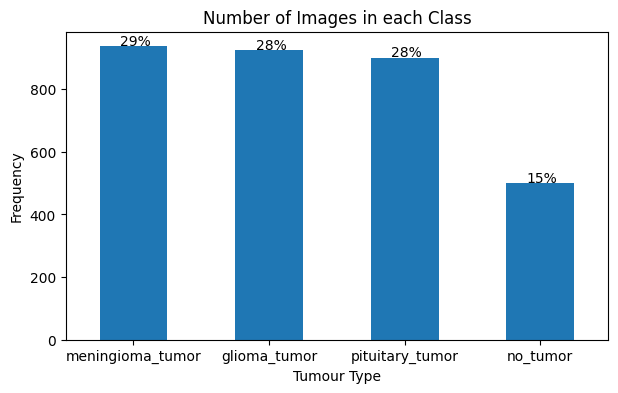

In [ ]:
# number of images in each class
ax = data['class'].value_counts().plot.bar(rot=0, figsize=(7,4))
for i in ax.patches:
  val = i.get_height()
  perc = val/len(data)*100
  plt.text(i.get_x()+0.15, val+3, f'{perc:.0f}%', fontsize=10)

plt.title('Number of Images in each Class')
plt.ylabel('Frequency')
plt.xlabel('Tumour Type')
plt.show()

__Plotting some images in all tumour classes__

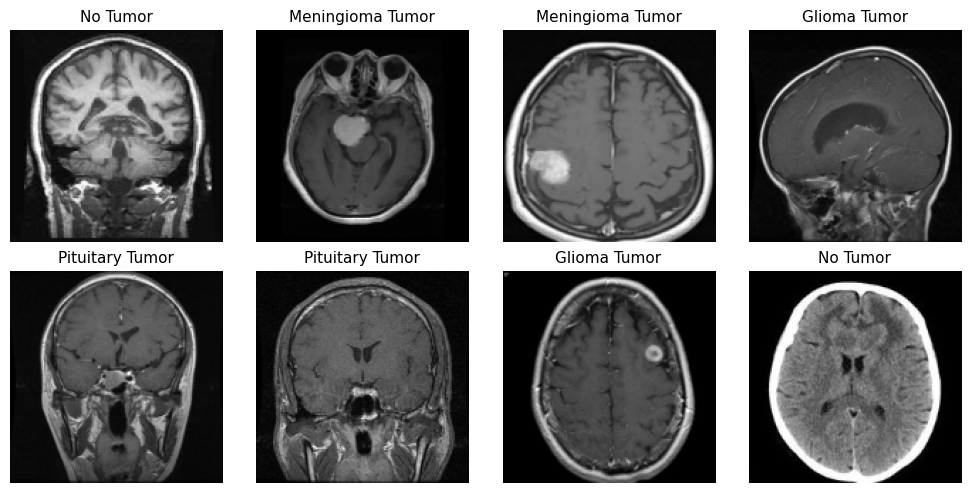

In [ ]:
sample_imgs = data.groupby('class').sample(2).sample(frac=1)

plt.figure(figsize=(10,5))
for i, (idx, img_info) in enumerate(sample_imgs.iterrows(), start=1):
  plt.subplot(2,4,i)
  img = skio.imread(img_info['image'])
  img = skcolor.rgb2gray(img) # converting to grayscale
  img = sktransform.resize(img, (150, 150))
  
  plt.imshow(img, cmap='gray')
  plt.title(img_info['class'].replace('_', ' ').title(), fontsize=11)
  plt.axis(False)
plt.tight_layout()
plt.show()

### Image Preparation and Preprocessing

Here we will extract features for dimensionality reduction using T-SNE and PCA. The dimensionally reduced features will be used for training machine learning models to classify tunour images.

Before that, we will do the following
- Convert Image to grayscale
- Resize image into 150 by 150
- Extract pixels from resized images
- Perform Dimensionality reduction techniques for visualisation and for model development.

In [ ]:
IMG_SIZE = (150,150)

In [ ]:
images = []

for img_name in tqdm(data['image']):
  img = imageio.imopen(img_name, io_mode='r', plugin='pillow').read()
  img = skcolor.rgb2gray(img) # converting to grayscale
  img = sktransform.resize(img, IMG_SIZE, anti_aliasing=True)
  images.append(img.flatten())

images = np.array(images)

100%|██████████| 3264/3264 [00:43<00:00, 75.32it/s]


__Data Augmentation__
- Here we will create new copies of the images in the training data
- Firstly, we will make the no_tumour images to be almost equal with the images of the other classes. This will reduce bias of the models towards the minority class.
- After that, we will randomly rotate the images of each class. The number of images to randomly generate will be determined by a set number

In [ ]:
def data_augmentation(img, flip=True, rotate=True):
  """Performs data augmentation purposes"""
  rotated_imgs = []
  if flip: # create mirror image
    hori_flip = np.flip(img.reshape(IMG_SIZE), axis=1)
    vert_flip = np.flip(img.reshape(IMG_SIZE), axis=0)
    rotated_imgs.append(vert_flip.flatten())
    rotated_imgs.append(hori_flip.flatten())
  if rotate:
    sample_angle = np.random.choice(np.arange(30,331,15))
    rotated_img = sktransform.rotate(img.reshape(IMG_SIZE), angle=sample_angle)
    rotated_imgs.append(rotated_img.flatten())
  rotated_imgs = np.array(rotated_imgs)
  return rotated_imgs

__Predicting Tumour types using Machine Learning Models__

In [ ]:
def train_model(model, x, y):
  model.fit(x, y)

def print_report(model, x, y):
  preds = model.predict(x)
  print(classification_report(y, preds, target_names=data['class'].unique()))

__Splitting into train and validation datasets__

In [ ]:
gc.collect()

20074

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(images, data['class'], stratify=data['class'], 
                                                random_state=42, test_size=0.1, shuffle=True)

In [ ]:
xtrain.shape, xtest.shape

((2937, 22500), (327, 22500))

In [ ]:
ytrain = ytrain.reset_index(drop=True)

In [ ]:
ytrain.value_counts()

meningioma_tumor    843
glioma_tumor        833
pituitary_tumor     811
no_tumor            450
Name: class, dtype: int64

In [ ]:
ytest.value_counts()

meningioma_tumor    94
glioma_tumor        93
pituitary_tumor     90
no_tumor            50
Name: class, dtype: int64

In [ ]:
# generate augmented data
np.random.seed(49)

train_imgs_aug = []
train_imgs_class = []

# sample image data from each tumour group
for group in tqdm(data['class'].unique()):
  if group == 'no_tumor':
    # get index of sampled data
    group_idx = ytrain[ytrain == group].sample(n=320, random_state=0).index
  else:
    group_idx = ytrain[ytrain == group].sample(n=200, random_state=0).index

  # perform data augmentation
  for idx in group_idx:
    img = xtrain[idx]
    aug_imgs = data_augmentation(img) # get imgs in each group_idx
    train_imgs_class.extend([group]*len(aug_imgs))
    train_imgs_aug.extend(aug_imgs)

train_imgs_aug = np.array(train_imgs_aug)
train_imgs_class = pd.Series(np.array(train_imgs_class))

assert np.array(train_imgs_aug).shape[0] == len(train_imgs_class) , ('Length not the same')

100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


In [ ]:
# add augmented data to xtrain
xtrain = np.r_[xtrain, train_imgs_aug]
ytrain = np.r_[ytrain, train_imgs_class]

In [ ]:
pd.Series(ytrain).value_counts()

meningioma_tumor    1443
glioma_tumor        1433
pituitary_tumor     1411
no_tumor            1410
dtype: int64

__Feature Reduction (Dimensionality Reduction using Principal Component Analysis (PCA))__ 

We will take the number of features that explains 95% of the variation in the data

In [ ]:
pca = PCA(n_components=0.95, random_state=0, whiten=True)
pca.fit(xtrain)

xtrain_pca = pca.transform(xtrain)
xtest_pca = pca.transform(xtest)

In [ ]:
# number of components with 95% variance
pca.n_components_

943

Instantiating Models

In [ ]:
skfold = StratifiedKFold(5, random_state=0, shuffle=True)

In [ ]:
def plot_confusion_matrix(model, x,y ):
  conf_mat = ConfusionMatrixDisplay.from_estimator(
      model, x, y, cmap='Greens', colorbar=False)
  plt.title(model.__class__.__name__)
  plt.xticks(rotation=90, fontsize=10)
  plt.show()

def grid_search(model, x, y, params, cv=skfold, scoring='accuracy'):
  gcv = GridSearchCV(model, params, scoring=scoring, cv=cv, n_jobs=8)
  gcv.fit(x, y)
  return gcv

### Modelling

__Logistic Regression__

In [ ]:
def fscorer(y, ypred):
  return f1_score(y, ypred, average='macro')

f_score = make_scorer(fscorer)

In [ ]:
logreg = LogisticRegression(C=0.08, random_state=0, max_iter=1500, penalty='l1', solver='liblinear')

In [ ]:
logreg.fit(xtrain_pca, ytrain)

LogisticRegression(C=0.08, max_iter=1500, penalty='l1', random_state=0,
                   solver='liblinear')

In [ ]:
print_report(logreg, xtest_pca, ytest)

                  precision    recall  f1-score   support

    glioma_tumor       0.77      0.77      0.77        93
meningioma_tumor       0.76      0.61      0.67        94
        no_tumor       0.68      0.68      0.68        50
 pituitary_tumor       0.81      0.98      0.88        90

        accuracy                           0.77       327
       macro avg       0.76      0.76      0.75       327
    weighted avg       0.76      0.77      0.76       327



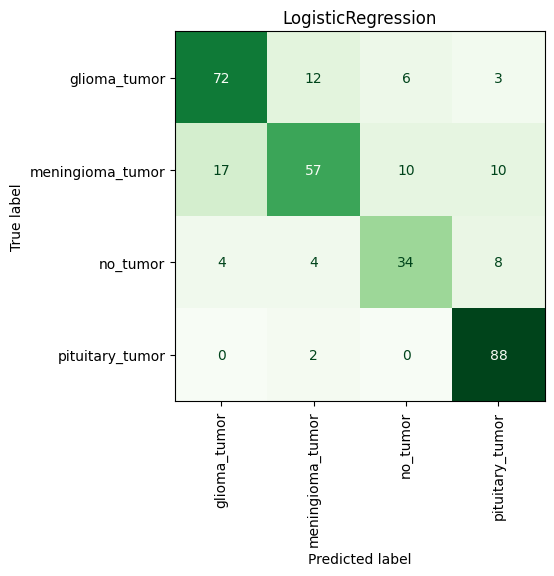

In [ ]:
plot_confusion_matrix(logreg, xtest_pca, ytest)

__KNearest Neighbours__

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2, p=1)
knn.fit(xtrain_pca, ytrain)

KNeighborsClassifier(n_neighbors=2, p=1)

In [ ]:
print_report(knn, xtest_pca, ytest)

                  precision    recall  f1-score   support

    glioma_tumor       0.54      0.99      0.70        93
meningioma_tumor       1.00      0.47      0.64        94
        no_tumor       0.73      0.64      0.68        50
 pituitary_tumor       1.00      0.76      0.86        90

        accuracy                           0.72       327
       macro avg       0.82      0.71      0.72       327
    weighted avg       0.83      0.72      0.72       327



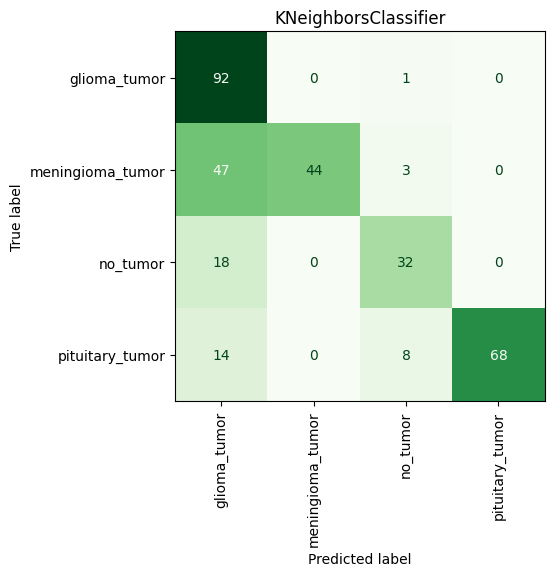

In [ ]:
plot_confusion_matrix(knn, xtest_pca, ytest)

In [ ]:
def eval_metric(model, x, y):
  pred = model.predict(x)
  acc = model.score(x, y)
  fscore = f1_score(y, pred, average='macro')
  print(f'Accuracy: {acc:.4f}\tF1-Score: {fscore:.4f}') 

In [ ]:
eval_metric(logreg, xtest_pca, ytest)

Accuracy: 0.7676	F1-Score: 0.7533


In [ ]:
eval_metric(knn, xtest_pca, ytest)

Accuracy: 0.7217	F1-Score: 0.7191


In [ ]:
# free memory
del images, xtrain, train_imgs_aug, xtest
del xtrain_pca, xtest_pca

In [ ]:
gc.collect()

3769

__Covolutional Neural Network__

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, utils
import tensorflow as tf

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
IMG_SIZE = 150,150,3

In [ ]:
images = []

for img_name in tqdm(data['image']):
  img = imageio.imopen(img_name, io_mode='r', plugin='pillow').read()
  img = sktransform.resize(img, IMG_SIZE, anti_aliasing=True)
  images.append(img)

images = np.array(images)

100%|██████████| 3264/3264 [01:37<00:00, 33.34it/s]


In [ ]:
gc.collect()

24

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(images, data['class'], stratify=data['class'], 
                                                random_state=42, test_size=0.1, shuffle=True)

In [ ]:
xtrain.shape, xtest.shape

((2937, 150, 150, 3), (327, 150, 150, 3))

In [ ]:
num_classes = data['class'].nunique()
num_classes

4

In [ ]:
class_labels = {i:j for i,j in zip(data['class'].unique(), range(num_classes))}
class_labels

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [ ]:
# convert class vectors to binary class matrices
ytrain = utils.to_categorical(ytrain.map(class_labels), num_classes)
ytest = utils.to_categorical(ytest.map(class_labels), num_classes)

In [ ]:
xtrain[0].min(), xtrain[0].max()

(0.0, 0.9992218261936067)

In [ ]:
model = keras.Sequential([
    keras.Input(shape=IMG_SIZE),
    layers.RandomFlip('horizontal_and_vertical', seed=42),
    layers.RandomRotation(factor=(-0.2, 0.2), seed=42),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1028, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")]
)

In [ ]:
def seed_all():
  np.random.seed(943)
  tf.random.set_seed(843)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])

In [ ]:
model_cp = keras.callbacks.ModelCheckpoint(
    filepath='./tmp/checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


early_stop = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=12)

In [ ]:
seed_all()
history = model.fit(xtrain, ytrain, epochs=50, validation_split=0.1, callbacks=[early_stop, model_cp])

Epoch 1/50
83/83 [==============================] - 18s 66ms/step - loss: 1.2180 - accuracy: 0.4366 - val_loss: 1.1714 - val_accuracy: 0.5136
Epoch 2/50
83/83 [==============================] - 4s 54ms/step - loss: 1.0200 - accuracy: 0.5656 - val_loss: 1.0291 - val_accuracy: 0.5816
Epoch 3/50
83/83 [==============================] - 4s 53ms/step - loss: 0.9161 - accuracy: 0.6160 - val_loss: 0.9491 - val_accuracy: 0.6327
Epoch 4/50
83/83 [==============================] - 3s 35ms/step - loss: 0.8546 - accuracy: 0.6481 - val_loss: 0.9374 - val_accuracy: 0.6327
Epoch 5/50
83/83 [==============================] - 5s 55ms/step - loss: 0.8348 - accuracy: 0.6455 - val_loss: 0.8488 - val_accuracy: 0.6633
Epoch 6/50
83/83 [==============================] - 8s 98ms/step - loss: 0.7762 - accuracy: 0.6837 - val_loss: 0.7341 - val_accuracy: 0.7449
Epoch 7/50
83/83 [==============================] - 3s 39ms/step - loss: 0.7296 - accuracy: 0.7011 - val_loss: 0.6676 - val_accuracy: 0.7347
Epoch 8/50
8

__Model Evaluation__

In [ ]:
model.evaluate(xtest, ytest)

11/11 [==============================] - 1s 43ms/step - loss: 0.2598 - accuracy: 0.9083


[0.2598172128200531, 0.9082568883895874]

In [ ]:
probabilities = model.predict(xtest)
predictions = probabilities.argmax(1)

11/11 [==============================] - 0s 11ms/step


In [ ]:
acc = accuracy_score(ytest.argmax(1), predictions)
fscore = f1_score(ytest.argmax(1), predictions, average='macro')
print(f'Accuracy: {acc:.4f}\tF1-Score: {fscore:.4f}')

Accuracy: 0.9083	F1-Score: 0.9100


In [ ]:
labels = list(class_labels.keys())

In [ ]:
print(classification_report(ytest.argmax(1), predictions, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.96      0.89        93
meningioma_tumor       0.93      0.83      0.88        94
        no_tumor       0.94      0.90      0.92        50
 pituitary_tumor       0.97      0.94      0.96        90

        accuracy                           0.91       327
       macro avg       0.92      0.91      0.91       327
    weighted avg       0.91      0.91      0.91       327



In [ ]:
conf_mat = pd.crosstab(ytest.argmax(1), predictions, rownames=['Actual'], colnames=['Predictions'])

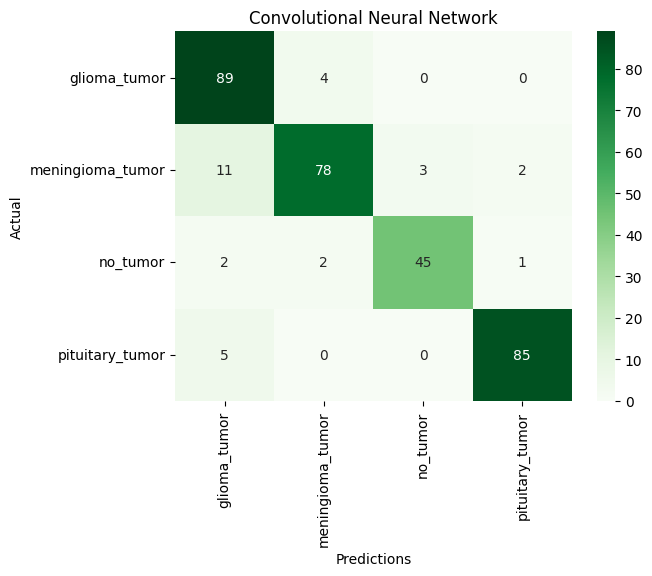

In [ ]:
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Greens', 
            yticklabels=labels, xticklabels=labels)
plt.title('Convolutional Neural Network')
plt.show()

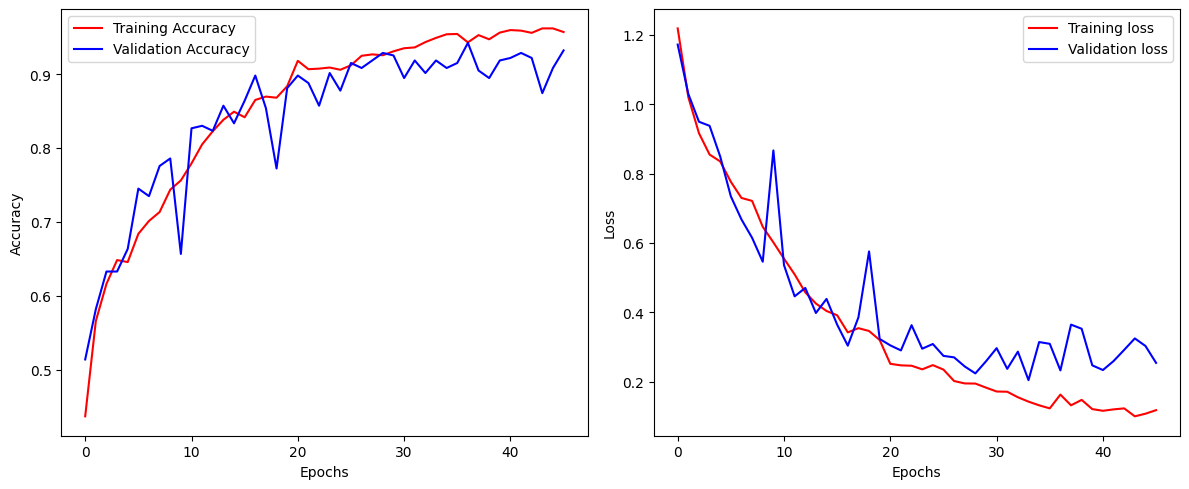

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(12,5))
# accuracy
ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
ax[0].set(xlabel='Epochs', ylabel='Accuracy')
ax[0].legend(loc='upper left')

# loss
ax[1].plot(epochs, loss,'r',label="Training loss")
ax[1].plot(epochs, val_loss,'b',label="Validation loss")
ax[1].set(xlabel='Epochs', ylabel='Loss')
ax[1].legend(loc='upper right')
fig.tight_layout()
plt.show()